In [1]:
train_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data-copia/Train' 
val_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data-copia/Val' 
test_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data-copia/Test'

In [2]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
#(100, 100, 3)
ih, iw = 100, 100 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 3 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size


Using TensorFlow backend.


In [3]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


In [4]:
train=train_generator
val=validation_generator
test=test_generator

In [5]:
from keras.applications import vgg16 
from keras.models import Model 
import keras 


vgg = vgg16.VGG16(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = vgg.layers[-5].output 
output = keras.layers.Flatten()(output) 
vgg_model = Model(vgg.input, output) 

 
vgg_model.trainable = True 
#set_trainable = False
 
#for layer in vgg_model.layers: 
#    if layer.name in ['block5_conv1', 'block4_conv1']: 
#        set_trainable = True 
#    if set_trainable: 
#        layer.trainable = True 
#    else: 
#        layer.trainable = False 

In [6]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\elium\.conda\envs\tfGPU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x0000022C123E7A88>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x0000022C10A41588>,block1_conv1,True
2,<keras.layers.convolutional.Conv2D object at 0x0000022C123E7A48>,block1_conv2,True
3,<keras.layers.pooling.MaxPooling2D object at 0x0000022C130CA548>,block1_pool,True
4,<keras.layers.convolutional.Conv2D object at 0x0000022C130CADC8>,block2_conv1,True
5,<keras.layers.convolutional.Conv2D object at 0x0000022C13128888>,block2_conv2,True
6,<keras.layers.pooling.MaxPooling2D object at 0x0000022C13128688>,block2_pool,True
7,<keras.layers.convolutional.Conv2D object at 0x0000022C1312C2C8>,block3_conv1,True
8,<keras.layers.convolutional.Conv2D object at 0x0000022C13137E08>,block3_conv2,True
9,<keras.layers.convolutional.Conv2D object at 0x0000022C1313EB48>,block3_conv3,True


In [7]:
from os import listdir
from os.path import isfile,isdir, join
import numpy

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Dropout,Activation,MaxPooling2D,Flatten
from keras.optimizers import RMSprop 
from sklearn.model_selection import train_test_split

In [8]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer 
from keras.models import Sequential 
from keras import optimizers  
import tensorflow as tf

# build model architecture 
model = Sequential() 

model.add(vgg_model) 
model.add(Dense(1024, activation='relu', input_dim=input_shape)) 
#model.add(Dropout(0.25)) 
model.add(Dense(512, activation='relu')) 
#model.add(Dropout(0.25))
model.add(Dense(256, activation='relu')) 
#model.add(Dropout(0.25))
model.add(Dense(num_class, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 18432)             7635264   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              18875392  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 771       
Total params: 27,167,555
Trainable params: 27,167,555
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit_generator(train, steps_per_epoch=8, 
                              epochs=100,  
                              validation_data=val,   
                              validation_steps=8,  
                              verbose=1)

Epoch 1/100
8/8 [==============================] - 5s 678ms/step - loss: 1.0616 - accuracy: 0.4688 - f1_m: 0.3392 - precision_m: 0.5139 - recall_m: 0.2578 - val_loss: 1.0047 - val_accuracy: 0.4375 - val_f1_m: 0.4179 - val_precision_m: 0.5602 - val_recall_m: 0.3398
Epoch 2/100
8/8 [==============================] - 1s 109ms/step - loss: 0.9789 - accuracy: 0.5234 - f1_m: 0.4859 - precision_m: 0.6736 - recall_m: 0.3906 - val_loss: 0.9017 - val_accuracy: 0.5664 - val_f1_m: 0.5975 - val_precision_m: 0.6538 - val_recall_m: 0.5586
Epoch 3/100
8/8 [==============================] - 1s 109ms/step - loss: 0.9476 - accuracy: 0.5430 - f1_m: 0.5449 - precision_m: 0.6714 - recall_m: 0.4727 - val_loss: 0.9232 - val_accuracy: 0.6680 - val_f1_m: 0.4618 - val_precision_m: 0.8122 - val_recall_m: 0.3242
Epoch 4/100
8/8 [==============================] - 1s 113ms/step - loss: 0.9471 - accuracy: 0.5352 - f1_m: 0.5291 - precision_m: 0.6585 - recall_m: 0.4648 - val_loss: 0.9855 - val_accuracy: 0.5664 - val_f1

Epoch 32/100
8/8 [==============================] - 1s 131ms/step - loss: 0.7306 - accuracy: 0.8086 - f1_m: 0.8116 - precision_m: 0.7900 - recall_m: 0.8359 - val_loss: 0.6943 - val_accuracy: 0.8789 - val_f1_m: 0.8789 - val_precision_m: 0.8544 - val_recall_m: 0.9062
Epoch 33/100
8/8 [==============================] - 1s 130ms/step - loss: 0.6944 - accuracy: 0.8516 - f1_m: 0.8353 - precision_m: 0.7936 - recall_m: 0.8828 - val_loss: 0.7014 - val_accuracy: 0.8359 - val_f1_m: 0.8278 - val_precision_m: 0.7960 - val_recall_m: 0.8633
Epoch 34/100
8/8 [==============================] - 1s 131ms/step - loss: 0.7546 - accuracy: 0.8047 - f1_m: 0.7899 - precision_m: 0.7657 - recall_m: 0.8164 - val_loss: 0.7409 - val_accuracy: 0.8359 - val_f1_m: 0.8326 - val_precision_m: 0.7921 - val_recall_m: 0.8789
Epoch 35/100
8/8 [==============================] - 1s 129ms/step - loss: 0.6615 - accuracy: 0.8984 - f1_m: 0.8719 - precision_m: 0.8375 - recall_m: 0.9102 - val_loss: 0.6765 - val_accuracy: 0.8867 - va

Epoch 63/100
8/8 [==============================] - 1s 129ms/step - loss: 0.7274 - accuracy: 0.8164 - f1_m: 0.8081 - precision_m: 0.7764 - recall_m: 0.8438 - val_loss: 0.6776 - val_accuracy: 0.9062 - val_f1_m: 0.8840 - val_precision_m: 0.8498 - val_recall_m: 0.9219
Epoch 64/100
8/8 [==============================] - 1s 134ms/step - loss: 0.7085 - accuracy: 0.8398 - f1_m: 0.8277 - precision_m: 0.7863 - recall_m: 0.8750 - val_loss: 0.6911 - val_accuracy: 0.8712 - val_f1_m: 0.8657 - val_precision_m: 0.8344 - val_recall_m: 0.9002
Epoch 65/100
8/8 [==============================] - 1s 126ms/step - loss: 0.6726 - accuracy: 0.8672 - f1_m: 0.8706 - precision_m: 0.8350 - recall_m: 0.9102 - val_loss: 0.6815 - val_accuracy: 0.8906 - val_f1_m: 0.8926 - val_precision_m: 0.8698 - val_recall_m: 0.9180
Epoch 66/100
8/8 [==============================] - 1s 129ms/step - loss: 0.6906 - accuracy: 0.8633 - f1_m: 0.8446 - precision_m: 0.8210 - recall_m: 0.8711 - val_loss: 0.6088 - val_accuracy: 0.8555 - va

Epoch 94/100
8/8 [==============================] - 1s 113ms/step - loss: 0.6520 - accuracy: 0.8867 - f1_m: 0.8880 - precision_m: 0.8502 - recall_m: 0.9297 - val_loss: 0.6821 - val_accuracy: 0.8750 - val_f1_m: 0.8693 - val_precision_m: 0.8175 - val_recall_m: 0.9297
Epoch 95/100
8/8 [==============================] - 1s 109ms/step - loss: 0.6642 - accuracy: 0.8828 - f1_m: 0.8804 - precision_m: 0.8438 - recall_m: 0.9219 - val_loss: 0.6356 - val_accuracy: 0.9297 - val_f1_m: 0.9079 - val_precision_m: 0.8774 - val_recall_m: 0.9414
Epoch 96/100
8/8 [==============================] - 1s 112ms/step - loss: 0.6982 - accuracy: 0.8438 - f1_m: 0.8405 - precision_m: 0.8035 - recall_m: 0.8828 - val_loss: 0.6206 - val_accuracy: 0.8125 - val_f1_m: 0.8247 - val_precision_m: 0.7935 - val_recall_m: 0.8594
Epoch 97/100
8/8 [==============================] - 1s 111ms/step - loss: 0.6686 - accuracy: 0.8789 - f1_m: 0.8685 - precision_m: 0.8374 - recall_m: 0.9023 - val_loss: 0.6619 - val_accuracy: 0.8984 - va

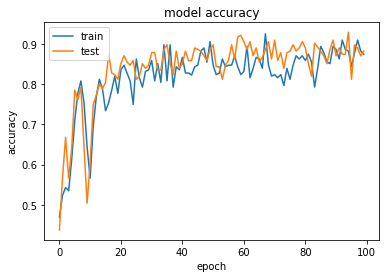

In [12]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

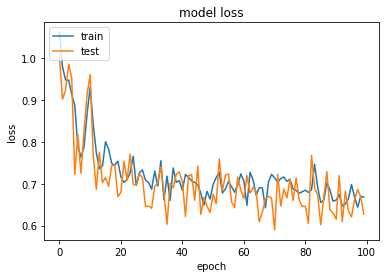

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

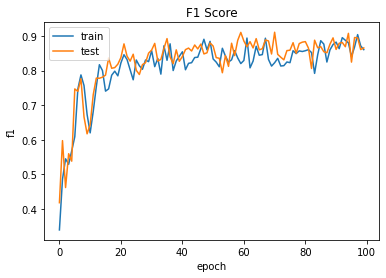

In [14]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

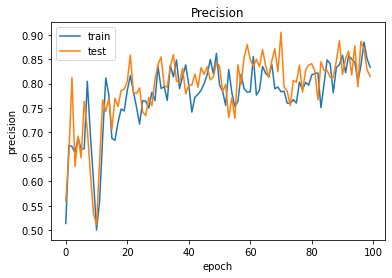

In [15]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

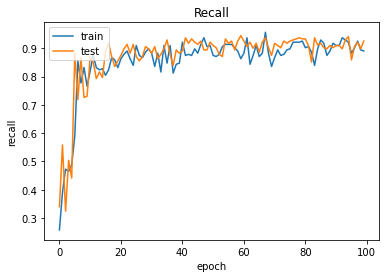

In [16]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

213/213 [==============================] - 28s 131ms/step
El modelo predice el  88.4796679019928 % de los datos


In [18]:
articulo_dir='D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Implementacion/Deteccion_Articulo/dataset,solocovid,pneumonia'
#Para el conjunto del artículo
articulo_generator = train_datagen.flow_from_directory(
    articulo_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data
articulo=articulo_generator

Found 351 images belonging to 2 classes.


In [19]:
print('Utilizando el conjunto de datos del artículo para evaluar el modelo')
test_eval = model.evaluate(articulo, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos del artículo para evaluar el modelo


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  logits and labels must be broadcastable: logits_size=[32,3] labels_size=[32,2]
	 [[node loss/dense_4_loss/categorical_crossentropy/softmax_cross_entropy_with_logits (defined at \.conda\envs\tfGPU\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]]
	 [[loss/dense_4_loss/categorical_crossentropy/weighted_loss/broadcast_weights/assert_broadcastable/AssertGuard/pivot_f/_15/_31]]
  (1) Invalid argument:  logits and labels must be broadcastable: logits_size=[32,3] labels_size=[32,2]
	 [[node loss/dense_4_loss/categorical_crossentropy/softmax_cross_entropy_with_logits (defined at \.conda\envs\tfGPU\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_keras_scratch_graph_2007]

Function call stack:
keras_scratch_graph -> keras_scratch_graph


In [43]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos de test para evaluar el modelo
142/142 [==============================] - 5s 35ms/step
El modelo predice el  97.68467545509338 % de los datos


In [44]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos de test para evaluar el modelo
Loss:  0.3677098751068115
Accuracy:  0.9768467545509338
F1 Score:  0.97563636302948
Precision:  0.9743842482566833
Recall:  0.9770265817642212


In [45]:
print('Utilizando el conjunto de datos del artículo para evaluar el modelo')
test_eval = model.evaluate(articulo, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos del artículo para evaluar el modelo
11/11 [==============================] - 4s 396ms/step
El modelo predice el  90.59829115867615 % de los datos


In [46]:
print('Utilizando el conjunto de datos del artículo para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos del artículo para evaluar el modelo
Loss:  0.46321430802345276
Accuracy:  0.9059829115867615
F1 Score:  0.9023765921592712
Precision:  0.8964685201644897
Recall:  0.9086326956748962


In [47]:
pred=model.predict(articulo)

In [48]:
#Aquí sólo hago con  un predict con el modelo y los datos del artículo
import numpy as np
suma=0
for i in range (351):
    if np.argmax(pred[i])==0:
        suma=suma+1
print(suma)

120
